<a href="https://colab.research.google.com/github/mahalakshmi9176349974/TNSDC_Generative-AI/blob/main/multi_modal_human_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  MULTI MODAL HUMAN ACTIVITY RECOGNITION AND PREDICTION IN SMART ENVIRONMENTS

This notebook provides basic example code to build, run, and fine-tune [MoViNets (Mobile Video Networks)](https://arxiv.org/pdf/2103.11511.pdf).

Pretrained models are provided by [TensorFlow Hub](https://tfhub.dev/google/collections/movinet/) and the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet), trained on [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) for video action classification. All Models use TensorFlow 2 with Keras for inference and training.

The following steps will be performed:

1. [Installation](#scrollTo=dPx7Pp7fbgLY&uniqifier=1)
2. [Download a subset of the UCF101 dataset](#scrollTo=KbhwWLLM7FXo&uniqifier=1)
3. [Download a pre-trained MoViNet model](#scrollTo=aYYShfhMx9DW&uniqifier=1)
4. [Save and load model](#scrollTo=YDk6LAciJfnA&uniqifier=1)
5. [Evaluate the model](#scrollTo=KkLl2zF8G9W0&uniqifier=1)
6. [Inferencing using the trained model on GIF](#scrollTo=6s9Q_JBcVmN1&uniqifier=1)

**Note: Enabling GPU Acceleration**

To utilize GPU acceleration in Colab, follow these steps:

1. Click on the "Runtime" menu at the top.
2. Select "Change runtime type" from the dropdown menu.
3. In the dialog box, choose "GPU" as the hardware accelerator.
4. Click on the "Save" button.

Enabling GPU will allow you to take advantage of faster computation for deep learning tasks.










## Installation



In [ ]:
%cd /content/

/content


In [ ]:
!mkdir video_classification
%cd video_classification

/content/video_classification


Install Dependencies: Run the following code block to install the necessary dependencies, including remotezip, tqdm, opencv-python, tf-models-official, and other required packages.

In [ ]:
%%capture
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official
!pip install remotezip
!pip install tf-models-official
!pip install -q mediapy


Import Libraries: Make sure to import the essential libraries for video processing, data manipulation, visualization, and deep learning operations. Include the following modules in your code:

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import os

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

import mediapy as media


With these installation and import steps completed, we are  ready to leverage the power of MoViNet for accurate video classification.

## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. We will use a subset of these categories in this demo.

These helper functions collectively assist in various stages of video processing, model loading, classification, and result visualization. They enhance the functionality and usability of the code by encapsulating specific tasks and making the code more modular and organized.

In [ ]:
#@title

def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]


def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [ ]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset.

In [ ]:
FILES_PER_CLASS = 100

In [ ]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

All the classes of UCF101 dataset

In [ ]:
classes

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BlowDryHair',
 'BlowingCandles',
 'BodyWeightSquats',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BreastStroke',
 'BrushingTeeth',
 'CleanAndJerk',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'CuttingInKitchen',
 'Diving',
 'Drumming',
 'Fencing',
 'FieldHockeyPenalty',
 'FloorGymnastics',
 'FrisbeeCatch',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HandstandWalking',
 'HeadMassage',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Knitting',
 'LongJump',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'MoppingFloor',
 'Nunchucks',
 'ParallelBars',
 'PizzaTossing',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'Play

These are the selected classes from the above classes list

In [ ]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

In [ ]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [ ]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [ ]:
files_subset = select_subset_of_classes(files_for_class, classes_1, FILES_PER_CLASS)
list(files_subset.keys())

['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [ ]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ucf_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [ ]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

The below URL contains a zip file with the UCF 101 dataset. Create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir,
                                       classes_1=classes_1)

train :


100%|██████████| 750/750 [02:19<00:00,  5.37it/s]


val :


100%|██████████| 250/250 [00:47<00:00,  5.28it/s]


test :


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


After downloading the data, we have have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 1250


## Create the training and test datasets

In [ ]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                          output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

The labels generated here represent the encoding of the classes. For instance, 'ApplyEyeMakeup' is mapped to the integer Take a look at the labels of the training data to ensure that the dataset has been sufficiently shuffled.

In [ ]:
for frames, labels in train_ds.take(NUM_CLASSES):
  print(labels)

tf.Tensor([13  8 15 24  7 17 22 22], shape=(8,), dtype=int16)
tf.Tensor([ 2  3  4 23  7 10 15  7], shape=(8,), dtype=int16)
tf.Tensor([ 4 16 19 23  3  1  9 22], shape=(8,), dtype=int16)
tf.Tensor([24 12  4 19 10 17 20 15], shape=(8,), dtype=int16)
tf.Tensor([ 5 21 11 13 22  0 24  3], shape=(8,), dtype=int16)
tf.Tensor([ 6 10 17  9 18 12 23 13], shape=(8,), dtype=int16)
tf.Tensor([ 6 11 13 16 22 20 12 15], shape=(8,), dtype=int16)
tf.Tensor([11 14 19  1 18  8 13 13], shape=(8,), dtype=int16)
tf.Tensor([19  8 18  0  0 19 20 11], shape=(8,), dtype=int16)
tf.Tensor([24  1 12 12  0  5  8  3], shape=(8,), dtype=int16)
tf.Tensor([ 8 11  1 18 12 24  8 13], shape=(8,), dtype=int16)
tf.Tensor([23  6 18 12  8 10  4  7], shape=(8,), dtype=int16)
tf.Tensor([21  4 22 19 21 17  4 23], shape=(8,), dtype=int16)
tf.Tensor([ 9  2  5 21  2 21 23  8], shape=(8,), dtype=int16)
tf.Tensor([ 8  0  8 13  7 20 22 14], shape=(8,), dtype=int16)
tf.Tensor([ 6 22 16 14 12  0 17 20], shape=(8,), dtype=int16)
tf.Tenso

Take a look at the shape of the data.

In [ ]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)


,,,,,,,

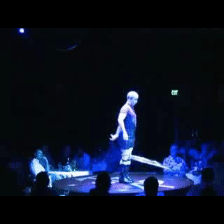
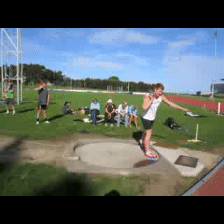
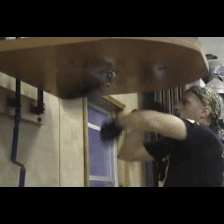
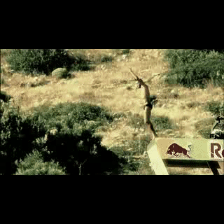
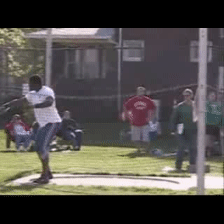
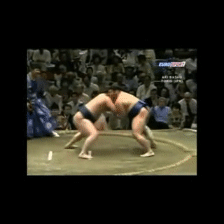
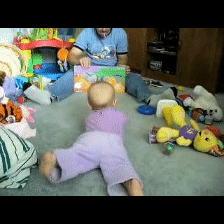
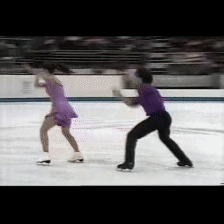

In [ ]:
videos, labels = next(iter(train_ds))
media.show_videos(videos.numpy(), codec='gif', fps=8)

## Download a pre-trained MoViNet model

In this section, we will:

1. We can create a MoViNet model using the open source code provided in [`official/projects/movinet`](https://github.com/tensorflow/models/tree/master/official/projects/movinet) from TensorFlow models.
2. Load the pretrained weights.
3. Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

To build the model, we can start with the `a0` configuration because it is the fastest to train when benchmarked against other models. Check out the [available MoViNet models on TensorFlow Model Garden](https://github.com/tensorflow/models/blob/master/official/projects/movinet/configs/movinet.py) to find what might work for our use case.

In [ ]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
batch_size, num_frames, resolution, backbone, NUM_CLASSES

(8,
 8,
 224,
 25)

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, NUM_CLASSES)

In [ ]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

For this project ,choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [ ]:
num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

Train the model. After two epochs, observe a low loss with high accuracy for both the training and test sets.

In [ ]:
train_ds, test_ds

(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int16, name=None))>)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

## Save and load model

This block contains codes for saving and loading trained models

In [ ]:
model.save('saved_model/my_model')

In [ ]:
# Download the zip file
from google.colab import files

files.download('/content/my_model.zip')

In [ ]:
import shutil

# Specify the folder path to be downloaded
folder_path = '/content/saved_model/my_model'  # Replace with the actual path to your folder

# Create a zip file of the folder
shutil.make_archive('/content/my_model', 'zip', folder_path)

In [ ]:
!unzip /content/my_model.zip -d /content/my_model

Archive:  /content/my_model.zip
   creating: /content/my_model/assets/
   creating: /content/my_model/variables/
  inflating: /content/my_model/keras_metadata.pb  
  inflating: /content/my_model/saved_model.pb  
  inflating: /content/my_model/fingerprint.pb  
  inflating: /content/my_model/variables/variables.index  
  inflating: /content/my_model/variables/variables.data-00000-of-00001  


In [ ]:
model = tf.keras.models.load_model('/content/my_model')

# Check its architecture
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [ ]:
model.evaluate(test_ds, return_dict=True)

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])
  plt.savefig("loss.png")
  plt.show()

plot_history(results)

Confusion matrix

In [ ]:
def get_actual_predicted_labels(model,dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
actual, predicted = get_actual_predicted_labels(model,test_ds)

32/32 [==============================] - 1589s 49s/step


In [ ]:
labels = classes_1

In [ ]:
print(actual, tf.cast(predicted, tf.int16),labels, len(labels),sep = '\n')

tf.Tensor(
[ 7  7  7  7  7  7  7  7  7  7  3  3  3  3  3  3  3  3  3  3 16 16 16 16
 16 16 16 16 16 16 18 18 18 18 18 18 18 18 18 18  5  5  5  5  5  5  5  5
  5  5 10 10 10 10 10 10 10 10 10 10  4  4  4  4  4  4  4  4  4  4 17 17
 17 17 17 17 17 17 17 17 14 14 14 14 14 14 14 14 14 14  8  8  8  8  8  8
  8  8  8  8  6  6  6  6  6  6  6  6  6  6  0  0  0  0  0  0  0  0  0  0
  9  9  9  9  9  9  9  9  9  9  1  1  1  1  1  1  1  1  1  1 13 13 13 13
 13 13 13 13 13 13 20 20 20 20 20 20 20 20 20 20 19 19 19 19 19 19 19 19
 19 19 21 21 21 21 21 21 21 21 21 21  2  2  2  2  2  2  2  2  2  2 22 22
 22 22 22 22 22 22 22 22 24 24 24 24 24 24 24 24 24 24 12 12 12 12 12 12
 12 12 12 12 23 23 23 23 23 23 23 23 23 23 15 15 15 15 15 15 15 15 15 15
 11 11 11 11 11 11 11 11 11 11], shape=(250,), dtype=int16)
tf.Tensor(
[ 8 21 21  8 23 17 17 10 17 21 10  3 21  4 23 20  3  3  0  3 10 10 23 10
  3 23 15 10 23 23  4  3  8  8  8  8  4 16 17  5  7  2  2  2  2 19  7 12
  2  2  2  8 23  8  8  2  2 23  8  2 22  2

In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns
import pandas as pd
con_mat = tf.math.confusion_matrix(labels=actual, predictions=predicted).numpy()
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat,
                     index = labels,
                     columns = labels)

figure = plt.figure(figsize=(9, 9))
sns.heatmap(con_mat_df, annot=True, fmt='g')
# sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion_martix_test.png',bbox_inches = 'tight')
plt.show()

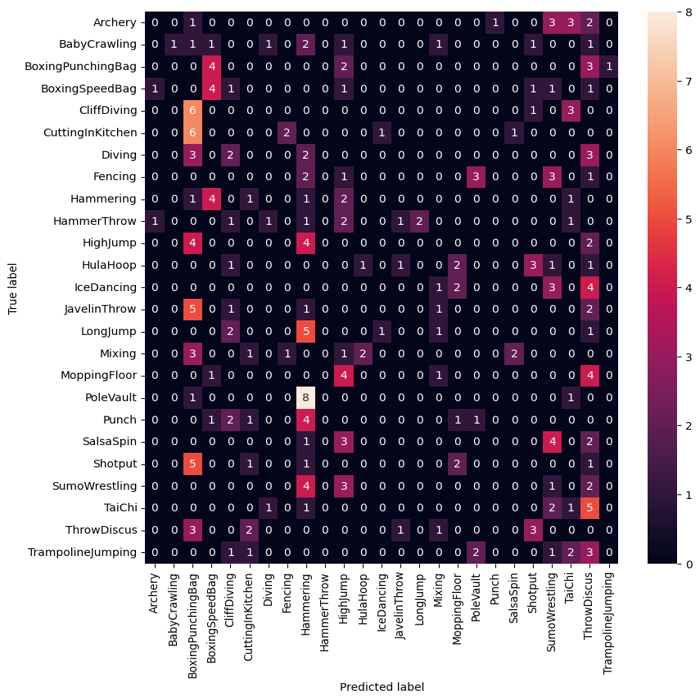

In [ ]:
from PIL import Image
import IPython.display as display

# Open the image
image_path = '/content/video_classification/Confusion_martix_test.png'  # Replace with the actual path to your image
image = Image.open(image_path)

# Define the desired output size
output_size = (700, 700)  # Replace with your desired size

# Resize the image
image_resized = image.resize(output_size)

# Display the resized image
display.display(image_resized)


## Inferencing using the trained model on GIF

The same can be done on video input by following bellow method

In case of video input with shape ```(1, N*8, 244, 244, 3)``` we can split it into multiple samples with size ```( 1, 8, 244, 244, 3)``` and do the inference in a loop to obtain realtime detection results

Check what the classes are and number of classes

In [ ]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

 The code takes a list of class labels `classes_1`, creates a list of unique classes, and generates one-hot encoded labels for each class in the original list. The resulting one-hot encoded labels are stored in the `labels_1` variable, which can be further used for tasks such as training machine learning models or performing categorical analysis.

In [ ]:
import numpy as np

classes_one_hot = classes_1

# Create a list of unique classes
unique_classes = np.unique(classes_one_hot)

# Create one-hot encoded labels
labels = []
for c in classes_1:
    label = np.asarray([1 if c == cls else 0 for cls in unique_classes])
    labels.append(label)

labels_1 = np.asarray(labels)

# print(labels_1)

The provided code is designed for video inference in order to visualize the predicted output. It includes helper `load_gif`, `get_top_k` and `predict_top_k` functions that have been defined to facilitate smooth execution.

In [ ]:
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k(probs, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

This folder is created for storing gif of the later use

In [ ]:
!mkdir sample_gifs

The purpose of the code below is to traverse through all the files in the '/content/video_classification/UCF101_subset/test' directory. It randomly selects five videos from this directory for inference. Subsequently, it converts these selected videos into GIF format and saves them in the '/content/video_classification/sample_gifs' folder. The generated GIFs can be used for future inference tasks.

In [ ]:
import os
import random
from moviepy.editor import VideoFileClip

# Specify the directory path
directory = '/content/video_classification/UCF101_subset/test'
save_dir = '/content/video_classification/sample_gifs'

# Get a list of subdirectories within the main directory
subdirectories = [subdir for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory, subdir))]


for i in range(5):
    subdir = random.choice(subdirectories)
    # Iterate over each subdirectory
    # for subdir in subdirectories:
    subdir_path = os.path.join(directory, subdir)
    # Get a list of files within the subdirectory with the .avi extension
    files = [file for file in os.listdir(subdir_path) if file.endswith('.avi')]

    # Randomly select a file from the files list
    random_file = random.choice(files)

    # Print the selected file
    print("Random .avi file from", subdir, ":", random_file)
    input = directory+'/'+subdir+'/'+random_file
    clip = VideoFileClip(input)
    output = save_dir+'/'+random_file.split('.')[0]+'.gif'
    print(output)
    clip.write_gif(output)


Random .avi file from CuttingInKitchen : v_CuttingInKitchen_g12_c01.avi
/content/video_classification/sample_gifs/v_CuttingInKitchen_g12_c01.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_CuttingInKitchen_g12_c01.gif with imageio.


Random .avi file from HulaHoop : v_HulaHoop_g15_c03.avi
/content/video_classification/sample_gifs/v_HulaHoop_g15_c03.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_HulaHoop_g15_c03.gif with imageio.


Random .avi file from CliffDiving : v_CliffDiving_g24_c04.avi
/content/video_classification/sample_gifs/v_CliffDiving_g24_c04.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_CliffDiving_g24_c04.gif with imageio.


Random .avi file from Archery : v_Archery_g18_c06.avi


/content/video_classification/sample_gifs/v_Archery_g18_c06.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_Archery_g18_c06.gif with imageio.


Random .avi file from TaiChi : v_TaiChi_g14_c03.avi
/content/video_classification/sample_gifs/v_TaiChi_g14_c03.gif
MoviePy - Building file /content/video_classification/sample_gifs/v_TaiChi_g14_c03.gif with imageio.



The provided code iterates through all the files in the '/content/video_classification/sample_gifs' directory. It utilizes these files for video classification and presents the output in the form of a GIF and displays the top five predictions associated with the video classification task.

In [ ]:
save_dir = '/content/video_classification/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(244, 244))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)

1/1 [==============================] - 187s 187s/step
HighJump 0.044302326
Diving 0.043348067
HammerThrow 0.042592704
BoxingSpeedBag 0.04231404
TaiChi 0.042248048


1/1 [==============================] - 123s 123s/step
TaiChi 0.044398513
CuttingInKitchen 0.04414063
HighJump 0.044128504
BoxingPunchingBag 0.043671668
SalsaSpin 0.042544723


1/1 [==============================] - 186s 186s/step
CuttingInKitchen 0.04348565
SalsaSpin 0.043309174
BoxingPunchingBag 0.043275855
TaiChi 0.042956118
Diving 0.04227386


1/1 [==============================] - 191s 191s/step
BoxingPunchingBag 0.045644943
HighJump 0.045234177
LongJump 0.04297435
ThrowDiscus 0.042695493
CuttingInKitchen 0.041953914


1/1 [==============================] - 92s 92s/step
HammerThrow 0.04382073
SalsaSpin 0.04367046
HulaHoop 0.04347024
MoppingFloor 0.04217351
Hammering 0.04192169
